### HWMId function with the support of Niclas Rieger (via GitHub)

In [2]:
from hwmid import Md
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import groupby
import multiprocessing as mp
import cartopy.crs as ccrs
from datetime import datetime
from functools import reduce
from itertools import repeat
import warnings
import time
import pandas as pd
from matplotlib.dates import DateFormatter
from matplotlib import gridspec
import matplotlib.dates as mdates

### Define function

In [3]:
def HWMId_JK (ds_full, grid_len, win = 31, q = 0.9, n_days =3, ref_period=['1979', '2010']):
    """
    Calculate the Heat wave magnitude index daily as defined by Russo et al. (2015)
    The index is derived using the following steps:
        1. Select the grid point
        2. Compute 366 day array with 0.9 quantiles defined with subsets using the values of the reference period in a 31-day window with the day centered on the window. These thresholds take care of the seasonality.
        3. Check whether the daily Tmax are above the daily 0.9 quantile thresholds
        4. Find the indices where there are at least 3 consecutive hot days -> Set heat waves shorter than 3 days to 0 
        5. Calculate the 0.25 quantile of annual maximum T_max in order to select hot temperatures 
        6. Return the daily magnitudes 'Md' using the formula defined by Russo et al. (2015) for hot days only (above 0.25 quantile of annual Tmaxs)
        7. Return the HWMId by calculating the cumulative of consecutive days with a daily magnitude
    """
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN slice encountered')
        ### 1. Select the grid point
        grid_points = [(lon, lat) for lat in ds_full.lat for lon in ds_full.lon] # Define tuples (lon, lat) with the length of lon*lat
        ds = ds_full.sel(lon=slice(grid_points[grid_len][0].lon, grid_points[grid_len][0].lon), lat=slice(grid_points[grid_len][1].lat, grid_points[grid_len][1].lat)).squeeze() # Select the grid-point data
        #ds=ds_full
        ### 2. Compute 366 day vector with 0.9 quantiles defined with subsets using the values of the reference period in a 31-day window with the day centered on the window. These thresholds take care of the seasonality. 
        plusminus = win // 2
        da_thresh_quantile= []
        for day in range(1,367):
            valid_days = (np.arange(day - plusminus - 1, day + plusminus) % 366) + 1
            window =  ds.sel(time=slice(ref_period[0]+'-01-01', ref_period[1]+'-12-31' )).time.dt.dayofyear.isin(valid_days)
            ds_win =  ds.where(window, drop=True)
            da_thresh_quantile.append(ds_win.quantile(q, dim='time', skipna=False))
        da_thresh_quantile_xr = xr.DataArray(data=xr.concat(da_thresh_quantile, dim='quantile'), dims=['dayofyear'], coords=dict(dayofyear=range(1,367)))

        ### 3. Check whether the daily Tmax are above the daily 0.9 quantile thresholds
        ds = ds.assign_coords(dayofyear=ds.time.dt.dayofyear) # Add the day-of-year coordinate to the dataset
        is_hot_bool = ds.groupby('time.dayofyear') > da_thresh_quantile_xr 

        ### 4. Find the indices where there are at least 3 consecutive hot days -> Set heat waves shorter than 3 days to 0
        convolution = np.convolve(is_hot_bool, np.ones(n_days, dtype=float), mode='valid') >= n_days
        indices = np.flatnonzero(convolution)
        indices = [indices + i for i in range(n_days)]
        idx_heatwave = reduce(np.union1d, (indices))
        idx_all = np.arange(len(is_hot_bool))
        heatw = np.where(np.isin(idx_all, idx_heatwave), is_hot_bool, 0)
        Td = ds.where(heatw !=0)

        ### 5. Calculate the 0.25 quantile of annual maximum T_max in order to select hot temperatures 
        T_ann_max = ds.sel(time=slice(ref_period[0]+'-01-01', ref_period[1]+'-12-31' )).groupby('time.year').max()
        T_ann_max_q25 = T_ann_max.quantile(0.25, dim='year')
        T_ann_max_q75 =  T_ann_max.quantile(0.75, dim='year')

        ### 6. Return the daily magnitudes 'Md' using the formula defined by Russo et al. (2015) for hot days only (above 0.25 quantile of annual Tmaxs)
        Md = (Td - T_ann_max_q25)/ (T_ann_max_q75 - T_ann_max_q25)
        Md_hot = Md.where(Td > T_ann_max_q25)

        ### 7. Calculate HWMId by a cumulative sum over consecutive values and choose maximum value of each year
        Md_hot_filled = Md_hot.fillna(0)
        eps = 1e-5  # to represent zero
        hw_mds = Md_hot_filled.groupby((Md_hot_filled < eps).cumsum('time')).apply(lambda x: x.cumsum(dim='time'))
        HWMId = hw_mds.groupby('time.year').max()


        return Md_hot, HWMId, T_ann_max_q75, T_ann_max_q25, Td, da_thresh_quantile_xr

In [4]:
################# Produce function that converts from 0-360 to -180 and +180
def wrapTo180(ds,longitude):

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_wrapped'] = xr.where(longitude > 180., longitude - 360., longitude)

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (ds.swap_dims({'lon': '_longitude_wrapped'})
          .sel(**{'_longitude_wrapped': sorted(ds._longitude_wrapped)}).drop('lon'))
    ds = ds.rename({'_longitude_wrapped': 'lon'})
    return ds
##################

### Load Maximum Temperature and show European example 

In [5]:
# Load data set with 1 degree resolution
work_dir='/work/bm1398/m301111'
ERA5_t2m_ds = xr.open_dataset(work_dir +'/Reanalysis/ERA5/ERA5__tmax__1979-2023_daymean_1_deg.nc')
lsm = xr.open_dataset(work_dir +'Reanalysis/ERA5/ERA5_lsm_1_deg.nc')
# Calc example 
ERA5_t2m_clim = ERA5_t2m_ds.mx2t.groupby('time.season').mean('time').sel(season='JJA') - 273.15
ERA5_t2m_clim_lsm = ERA5_t2m_clim.where(lsm.lsm!=0).squeeze()

### Show Map of European/USA T2m and of European/USA T2m with lsm

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


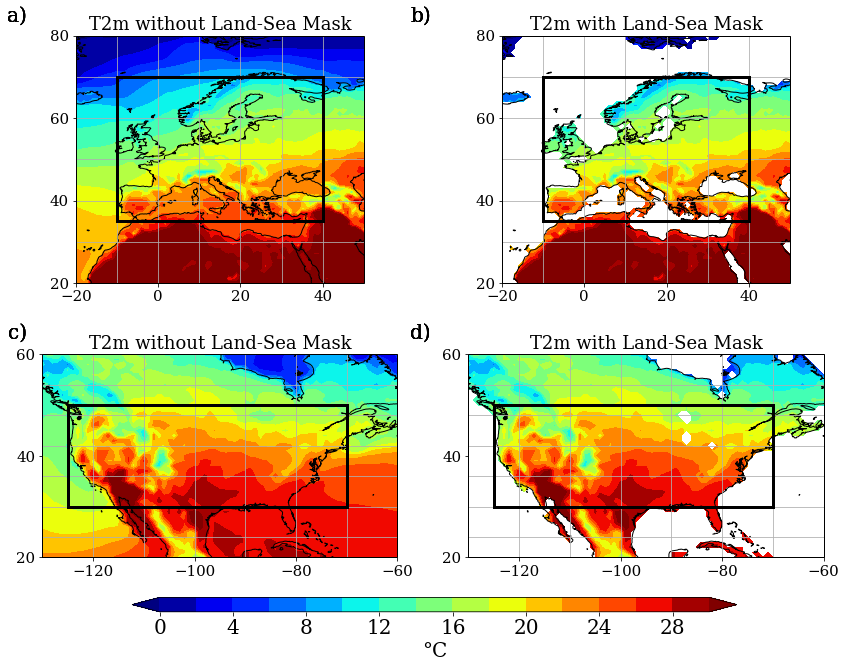

In [6]:
# Set general font size
plt.rcParams['font.size'] = '15'
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# Define projection and 2x2 subplots
prj = ccrs.PlateCarree()
# Calc X and Y with extended longitude vector
X, Y = (np.meshgrid(np.linspace(0,360,361), ERA5_t2m_ds['lat']))
fig = plt.figure(figsize=(14,10))
axs = []
for i in range(1,5):
    axs.append(fig.add_subplot(2,2,i,projection=prj))
# Define contourIntervals as well as values and properties for the boxes
levels=np.linspace(0,40)
# Show European box
x1, y1 = [-10, 40], [35, 35]
x2, y2 = [-10, 40], [70, 70]
x3, y3 = [-10, -10], [35, 70]
x4, y4 = [40, 40], [35, 70]

# Show USA box
x5, y5 = [-125, -70], [30, 30]
x6, y6 = [-125, -70], [50, 50]
x7, y7 = [-125, -125], [30, 50]
x8, y8 = [-70, -70], [30, 50]

# Show Japan box
x9, y9 = [130, 145], [30, 30]
x10, y10 = [130, 145], [45, 45]
x11, y11 = [130, 130], [30, 45]
x12, y12 = [145, 145], [30, 45]

color = ['black']
levels=np.linspace(0,30,16)
title = ['T2m without Land-Sea Mask', 'T2m with Land-Sea Mask','T2m without Land-Sea Mask', 'T2m with Land-Sea Mask','T2m without LSM', 'T2m with LSM']
data= [ERA5_t2m_clim.sel(expver=1).combine_first(ERA5_t2m_clim.sel(expver=5)), ERA5_t2m_clim_lsm.sel(expver=1).combine_first(ERA5_t2m_clim_lsm.sel(expver=5)),
       ERA5_t2m_clim.sel(expver=1).combine_first(ERA5_t2m_clim.sel(expver=5)), ERA5_t2m_clim_lsm.sel(expver=1).combine_first(ERA5_t2m_clim_lsm.sel(expver=5)),
       ERA5_t2m_clim.sel(expver=1).combine_first(ERA5_t2m_clim.sel(expver=5)), ERA5_t2m_clim_lsm.sel(expver=1).combine_first(ERA5_t2m_clim_lsm.sel(expver=5))]

# Plot climatologies with and without mask
for i in range(0,4):    
    cont = axs[i].contourf(X,Y,np.c_[data[i], data[i][:,0]],cmap='jet', transform =prj, levels=levels, extend='both')
    axs[i].plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=3)
    axs[i].set_title(title[i])
    if i<2:
        axs[i].set_extent([-20, 50, 20, 80], ccrs.PlateCarree())
        axs[i].set_xticks([-20, 0, 20, 40,], crs=ccrs.PlateCarree())
        axs[i].set_yticks([20, 40, 60, 80], crs=ccrs.PlateCarree())
        axs[i].plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=3)

    if i>=2 and i<4:
        axs[i].set_extent([-130, -60, 20, 60], ccrs.PlateCarree())
        axs[i].set_xticks([-120, -100, -80, -60], crs=ccrs.PlateCarree())
        axs[i].set_yticks([20, 40, 60], crs=ccrs.PlateCarree())
        axs[i].plot(x5, y5, x6, y6,x7,y7,x8,y8, color='black', linestyle='-', linewidth=3)
                
#axs[0].text(35,88,'Summer (JJA) climatology', fontweight='bold', fontsize=20)
for ax in axs:
    ax.coastlines('50m')
    ax.gridlines()
    
    plt.figtext(0.1,0.92,"a)", ha="center", va="top", fontsize=20)
    plt.figtext(0.5,0.92, "b)", ha="center", va="top", fontsize=20)
    plt.figtext(0.1,0.48,"c)", ha="center", va="top", fontsize=20)
    plt.figtext(0.5,0.48,"d)", ha="center", va="top", fontsize=20)
    
cb_ax = fig.add_axes([0.214, 0.08, 0.6, 0.02])
cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='°C', fontsize=20)
#rasterize_list = [axs[s] for s in range(4)]
#raster.rasterize_and_save('HWMId_JK/figs/ERA5_Europe_USA_Japan_maps_lsm_1979_2022_JJA_clim.png', rasterize_list, dpi=300)

### Select data, wrap longitudes from 0-360° to -180 - +180° and select masked (lsm) data for ...

In [7]:
ERA5_t2m = ERA5_t2m_ds.sel(expver=1).combine_first(ERA5_t2m_ds.sel(expver=5))

ERA5_t2m_wrapped = wrapTo180(ERA5_t2m, ERA5_t2m.lon)
lsm_wrapped = wrapTo180(lsm.lsm, lsm.lon)

* Europe

In [8]:
ERA5_t2mx_Europe = ERA5_t2m_wrapped.mx2t.where(lsm_wrapped.squeeze()!=0).sel(lon=slice(-10.0,40.0), lat=slice(35.0, 70.0))- 273.15
print(ERA5_t2mx_Europe.shape)

(16436, 36, 51)


* USA 

In [9]:
ERA5_t2mx_USA = ERA5_t2m_wrapped.mx2t.where(lsm_wrapped.squeeze()!=0).sel(lon=slice(-125.0,-70.0), lat=slice(30.0, 50.0))- 273.15
print(ERA5_t2mx_USA.shape)

(16436, 21, 56)


### Calculate HWMId for grid points individually using parallel processing for ...

* Europe

In [10]:
start = time.time()                                                                                                              # Grab Currrent Time Before Running the Code
pool = mp.Pool(processes=64)                                                                                                     # Create a pool of processes
HWMId_Europe = pool.starmap(HWMId_JK, zip(repeat(ERA5_t2mx_Europe), range(len(ERA5_t2mx_Europe.lon)*len(ERA5_t2mx_Europe.lat)))) # Apply the function to each grid point using parallel processing
print('It took', time.time()-start, 'seconds.')

It took 857.1422946453094 seconds.


* USA

In [11]:
start = time.time()                                                                                                              # Grab Currrent Time Before Running the Code
pool = mp.Pool(processes=64)                                                                                                     # Create a pool of processes
HWMId_USA = pool.starmap(HWMId_JK, zip(repeat(ERA5_t2mx_USA), range(len(ERA5_t2mx_USA.lon)*len(ERA5_t2mx_USA.lat))))             # Apply the function to each grid point using parallel processing
print('It took', time.time()-start, 'seconds.')

It took 539.3109579086304 seconds.


### Combine grid point time series to a Array with dims (year x lat x lon) for 
#### 1. HWMId  
#### 2. Daily Heat Wave Magnitudes
* Europe

In [12]:
### 1. HWMId ###

HWMID_lat_lon_Europe = []
idx= np.arange(0,len(ERA5_t2mx_Europe.lon))
for lat in range(len(ERA5_t2mx_Europe.lat)):
    HWMID_lat_lon_Europe.append(xr.concat([HWMId_Europe[lon][1] for lon in idx], dim='lon'))
    idx=idx+len(ERA5_t2mx_Europe.lon)
HWMID_lat_lon_Europe_xr = xr.concat(HWMID_lat_lon_Europe, dim='lat').transpose('year','lat','lon')
print(HWMID_lat_lon_Europe_xr.shape)

### 2. Daily Heatwave magnitudes ###

Md_lat_lon_Europe = []
idx= np.arange(0,len(ERA5_t2mx_Europe.lon))
for lat in range(len(ERA5_t2mx_Europe.lat)):
    Md_lat_lon_Europe.append(xr.concat([HWMId_Europe[lon][0] for lon in idx], dim='lon'))
    idx=idx+len(ERA5_t2mx_Europe.lon)
Md_lat_lon_Europe_xr = xr.concat(Md_lat_lon_Europe, dim='lat').transpose('time','lat','lon')
print(Md_lat_lon_Europe_xr.shape)

(45, 36, 51)
(16436, 36, 51)


* USA

In [13]:
### 1. HWMId ###

HWMID_lat_lon_USA = []
idx= np.arange(0,len(ERA5_t2mx_USA.lon))
for lat in range(len(ERA5_t2mx_USA.lat)):
    HWMID_lat_lon_USA.append(xr.concat([HWMId_USA[lon][1] for lon in idx], dim='lon'))
    idx=idx+len(ERA5_t2mx_USA.lon)
HWMID_lat_lon_USA_xr = xr.concat(HWMID_lat_lon_USA, dim='lat').transpose('year','lat','lon')
print(HWMID_lat_lon_USA_xr.shape)

### 2. Daily Heatwave magnitudes ###

Md_lat_lon_USA = []
idx= np.arange(0,len(ERA5_t2mx_USA.lon))
for lat in range(len(ERA5_t2mx_USA.lat)):
    Md_lat_lon_USA.append(xr.concat([HWMId_USA[lon][0] for lon in idx], dim='lon'))
    idx=idx+len(ERA5_t2mx_USA.lon)
Md_lat_lon_USA_xr = xr.concat(Md_lat_lon_USA, dim='lat').transpose('time','lat','lon')
print(Md_lat_lon_USA_xr.shape)

(45, 21, 56)
(16436, 21, 56)


## Show illustration of methodology

['2015-01-01T09:00:00.000000000']


(0.0, 35.0)

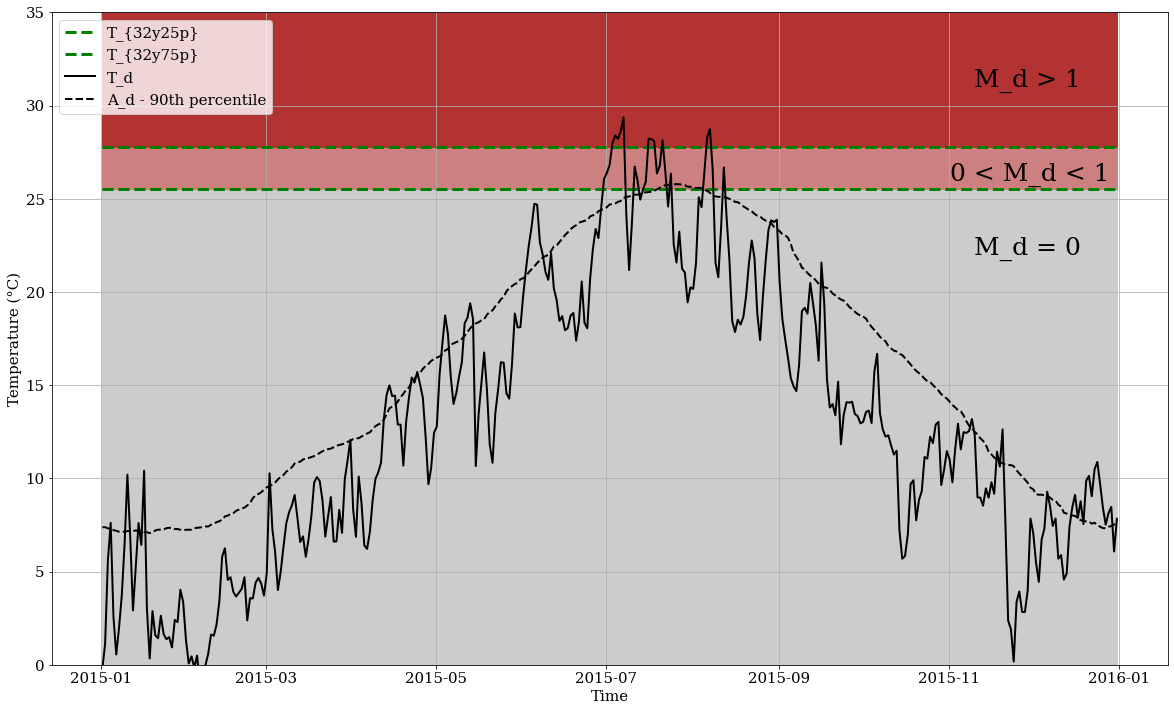

In [14]:
grid_point=525 # Example grid point (5°W, 45°N)

fig = plt.figure(figsize=(20,12))
axs = []
for i in range(1,2):
    axs.append(fig.add_subplot(1,1,i))
print(HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00', '2015-01-01T09:00:00')).time.values)
# Show 25 and 75 percentile of 32 year Tmaxs
axs[0].plot([HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00', '2015-01-01T09:00:00')).time.values, 
             HWMId_Europe[grid_point][4].sel(time=slice('2015-12-31T09:00:00', '2015-12-31T09:00:00')).time.values],
             [HWMId_Europe[grid_point][3].values, 
             HWMId_Europe[grid_point][3].values],
             lw=3, color='green', ls='--', label ='T_{32y25p}')
axs[0].plot([HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00', '2015-01-01T09:00:00')).time.values, 
             HWMId_Europe[grid_point][4].sel(time=slice('2015-12-31T09:00:00', '2015-12-31T09:00:00')).time.values],
             [HWMId_Europe[grid_point][2].values, 
             HWMId_Europe[grid_point][2].values],
             lw=3, color='green', ls='--', label ='T_{32y75p}')

# Show Td and 90th percentile thresholds
axs[0].plot(HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00','2015-12-31T09:00:00')).time, ERA5_t2mx_Europe.sel(lat=45.0, lon=5.0,time=slice('2015-01-01T09:00:00','2015-12-31T09:00:00')), lw=2, color='black', label ='T_d')
axs[0].plot(HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00','2015-12-31T09:00:00')).time, HWMId_Europe[grid_point][5].sel(dayofyear=slice(1,365)), lw=2, color='black', ls='--', label ='A_d - 90th percentile')

axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature (°C)')
axs[0].text(HWMId_Europe[grid_point][4].sel(time=slice('2015-11-01T09:00:00', '2015-11-01T09:00:00')).time.values, 22, '   M_d = 0', fontsize=25)
axs[0].text(HWMId_Europe[grid_point][4].sel(time=slice('2015-11-01T09:00:00', '2015-11-01T09:00:00')).time.values, 26, '0 < M_d < 1', fontsize=25)
axs[0].text(HWMId_Europe[grid_point][4].sel(time=slice('2015-11-01T09:00:00', '2015-11-01T09:00:00')).time.values, 31, '   M_d > 1', fontsize=25)

axs[0].fill_between(HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00', '2015-12-31T09:00:00')).time.values, 0,HWMId_Europe[grid_point][3].values, color=[0.8, 0.8,0.8])
axs[0].fill_between(HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00', '2015-12-31T09:00:00')).time.values, HWMId_Europe[grid_point][2].values ,HWMId_Europe[grid_point][3].values, color=[0.8, 0.5,0.5])
axs[0].fill_between(HWMId_Europe[grid_point][4].sel(time=slice('2015-01-01T09:00:00', '2015-12-31T09:00:00')).time.values, HWMId_Europe[grid_point][2].values ,35, color=[0.7, 0.2,0.2])
axs[0].grid()
axs[0].legend(loc=2)
axs[0].set_ylim(0,35)

### Plot HWMId for all 44 years
* Europe
* USA
* Japan

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


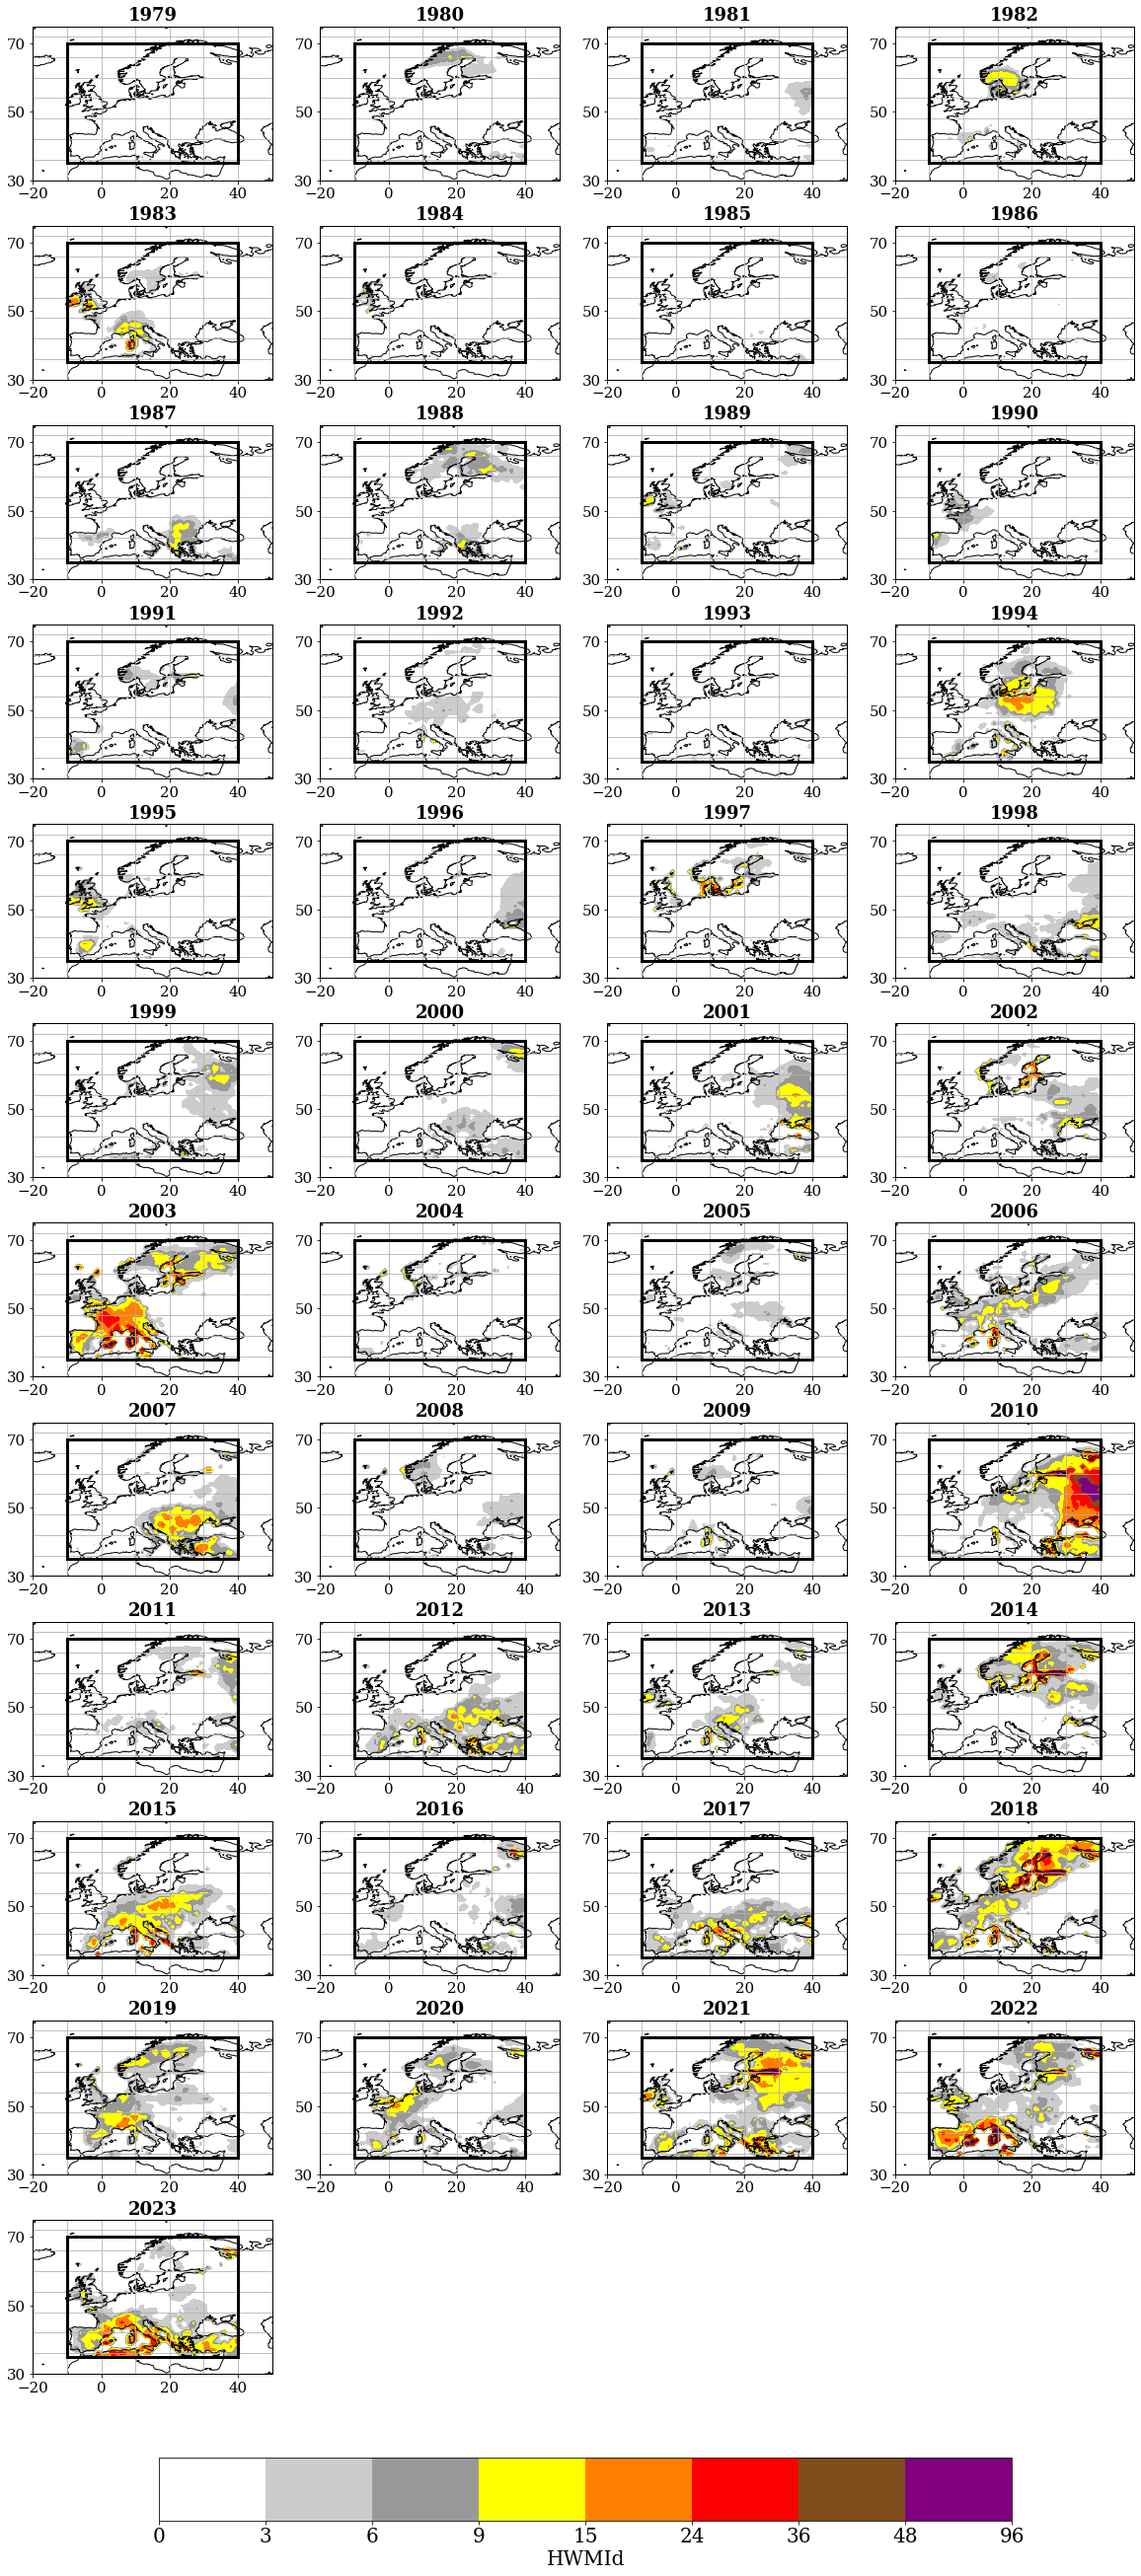

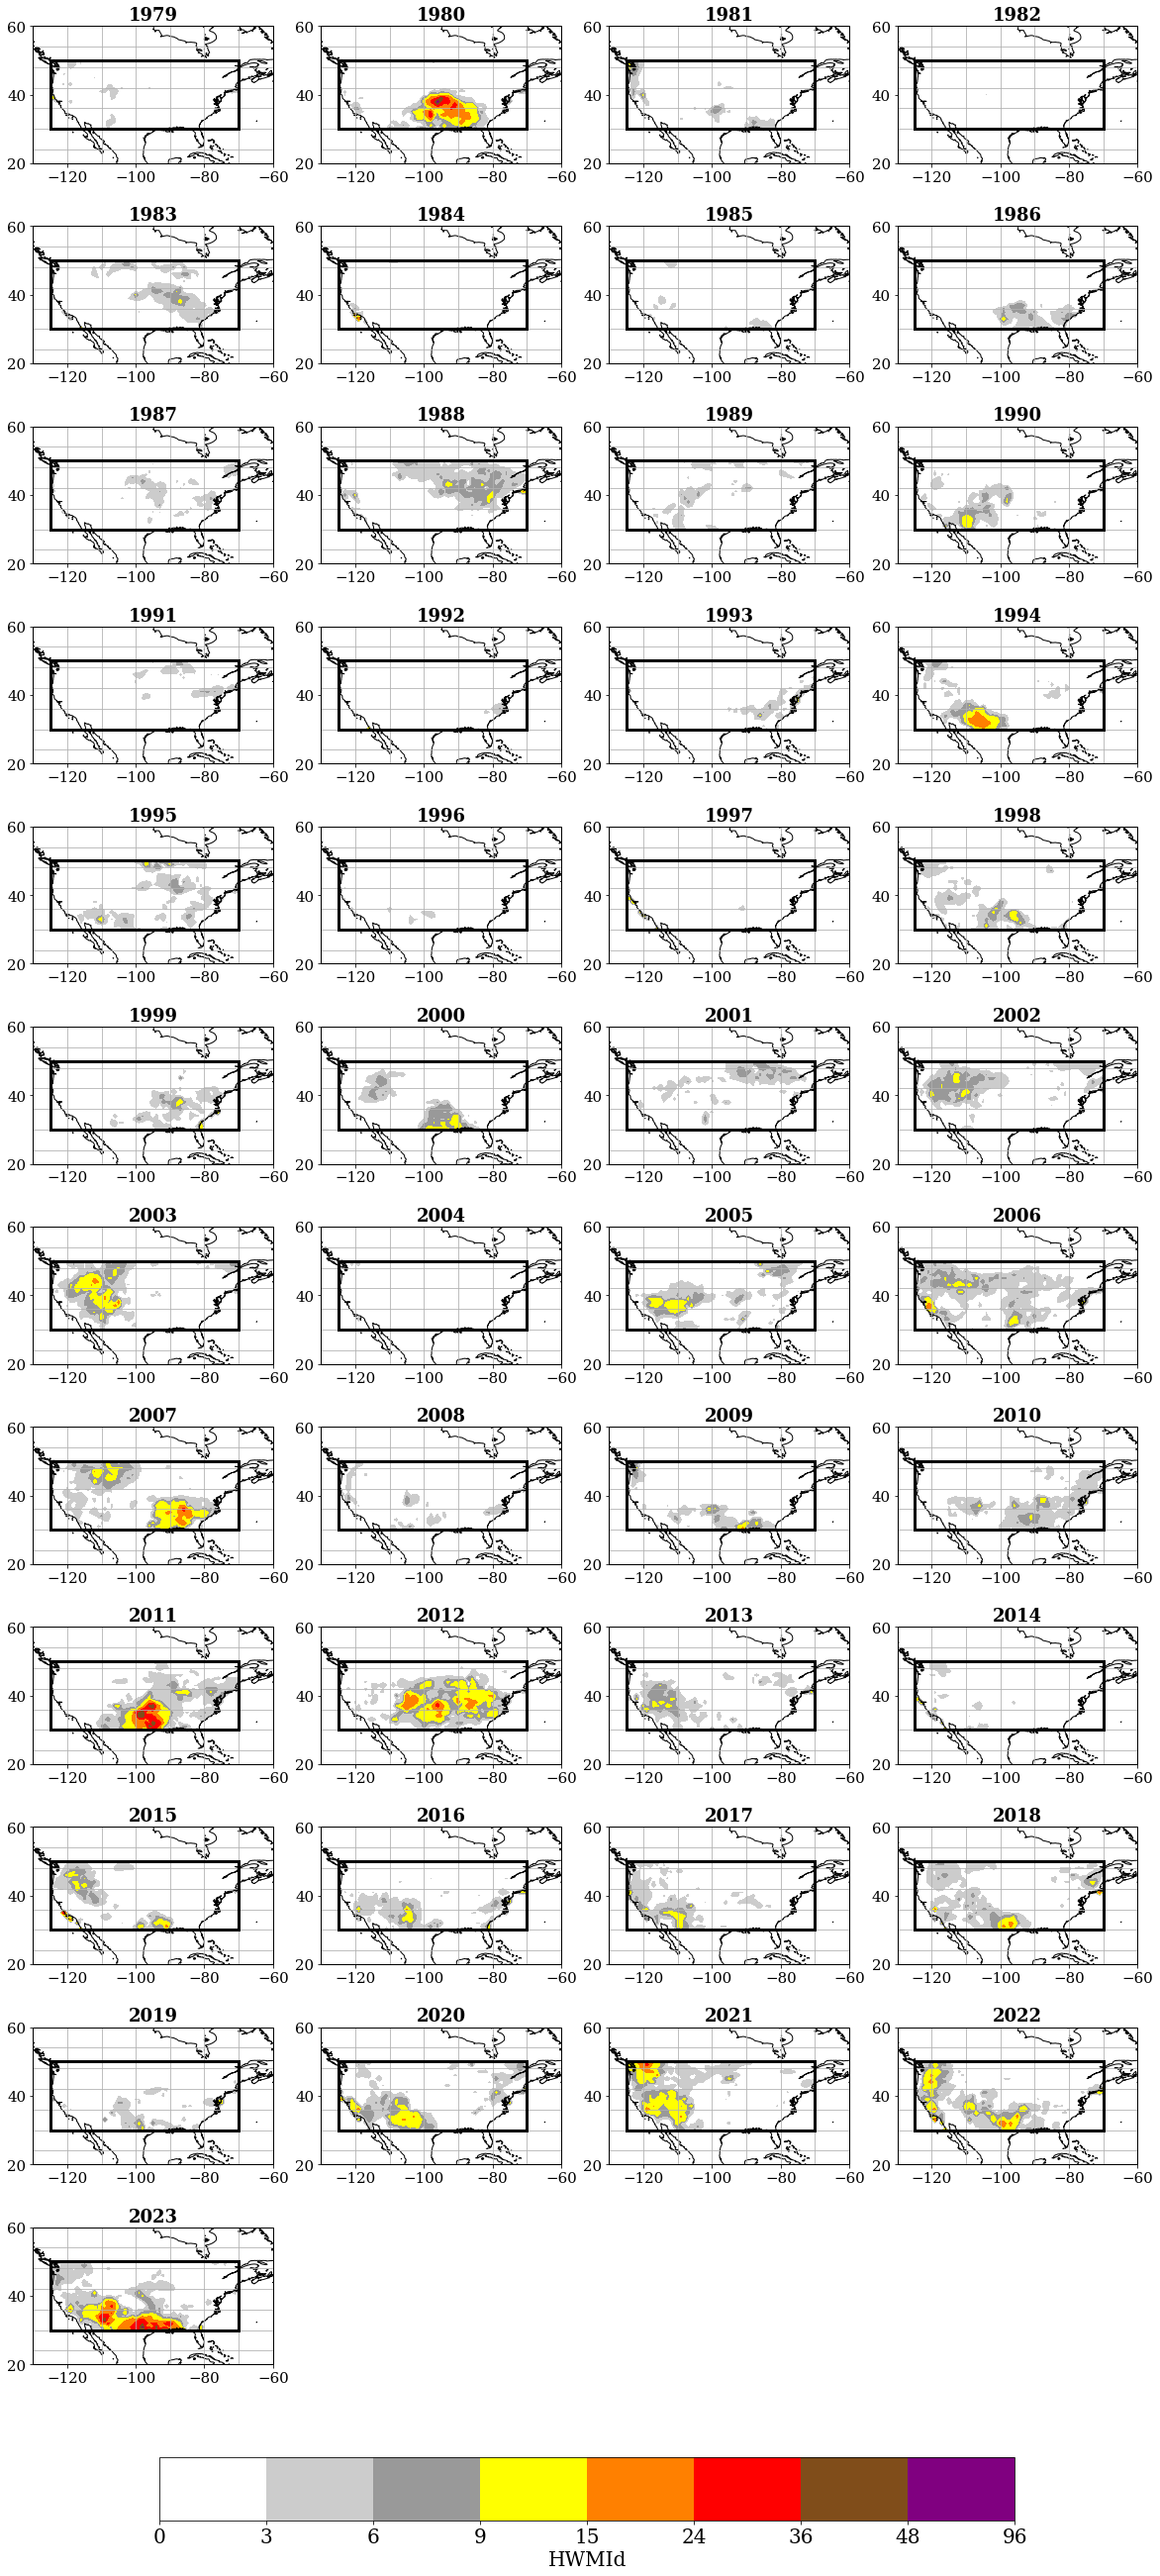

In [42]:
# Set general font size
plt.rcParams['font.size'] = '15'
# Define projection
prj = ccrs.PlateCarree()
levels= np.array([0,3,6,9,15,24,36,48,96])
years = [str(year) for year in range(1979, 2024)]

# Create non-linear level-spaced colormap, used in Russo et al. 2015
colors = [(1, 1, 1),             # white
          (0.8, 0.8, 0.8),       # light grey
          (0.6, 0.6, 0.6),       # dark grey
          (1, 1, 0),             # yellow
          (1, 0.5, 0),           # light red
          (1, 0, 0),             # red
          (0.5, 0.3, 0.1),       # brown
          (0.5, 0, 0.5)]         # purple
cmap = plt.cm.colors.ListedColormap(colors)
# Create a norm object using BoundaryNorm
norm = plt.cm.colors.BoundaryNorm(levels, cmap.N)
X_Europe, Y_Europe = (HWMID_lat_lon_Europe_xr.lon, HWMID_lat_lon_Europe_xr.lat)
X_USA, Y_USA = (HWMID_lat_lon_USA_xr.lon, HWMID_lat_lon_USA_xr.lat)
#X_Japan, Y_Japan = (HWMID_lat_lon_Japan_xr.lon, HWMID_lat_lon_Japan_xr.lat)

X= [X_Europe, X_USA]#, X_Japan]
Y= [Y_Europe, Y_USA]#, Y_Japan]
Z= [HWMID_lat_lon_Europe_xr, HWMID_lat_lon_USA_xr]#, HWMID_lat_lon_Japan_xr]

for r in range(len(Z)):
    fig = plt.figure(figsize=(20,44))
    axs=[]
    for i in range(1,46):
            axs.append(fig.add_subplot(12,4,i, projection=prj))

    for j in range(0,45):
        contf= axs[j].contourf(X[r],Y[r], Z[r].sel(year=slice(Z[r].year[j],Z[r].year[j])).squeeze(), cmap=cmap, levels=levels, transform=prj, norm=norm)
        axs[j].set_title(years[j], fontweight='bold')
        if r==0:
            axs[j].plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=3)
            axs[j].set_extent([-20, 50, 30, 75], prj)
            axs[j].set_xticks([-20, 0,20, 40],crs=prj)
            axs[j].set_yticks([30, 50, 70],crs=prj)
        elif r==1:
            axs[j].plot(x5, y5, x6, y6,x7,y7,x8,y8, color='black', linestyle='-', linewidth=3)
            axs[j].set_extent([-130, -60, 20, 60], prj)
            axs[j].set_xticks([-120,-100, -80, -60],crs=prj)
            axs[j].set_yticks([20, 40, 60],crs=prj)
        elif r==2:
            axs[j].plot(x9, y9, x10, y10,x11,y11,x12,y12, color='black', linestyle='-', linewidth=3)
            axs[j].set_extent([120, 160, 25, 50], prj)
            axs[j].set_xticks([120, 140, 160], crs=prj)
            axs[j].set_yticks([30,40, 50], crs=prj)
    for ax in axs:
        ax.coastlines('50m')
        #ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
        #ax.text(0.5, -0.3, 'Longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
        ax.gridlines()

    cb_ax = fig.add_axes([0.214, 0.08, 0.6, 0.02])
    cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
    cb.ax.tick_params(labelsize=20)
    cb.set_label(label='HWMId', fontsize=20)

    rasterize_list = [axs[s] for s in range(45)]
    raster.rasterize_and_save('HWMId_JK/figs/ERA5_'+region[r]+'_HWMId_1979_2023.pdf', rasterize_list, dpi=300)

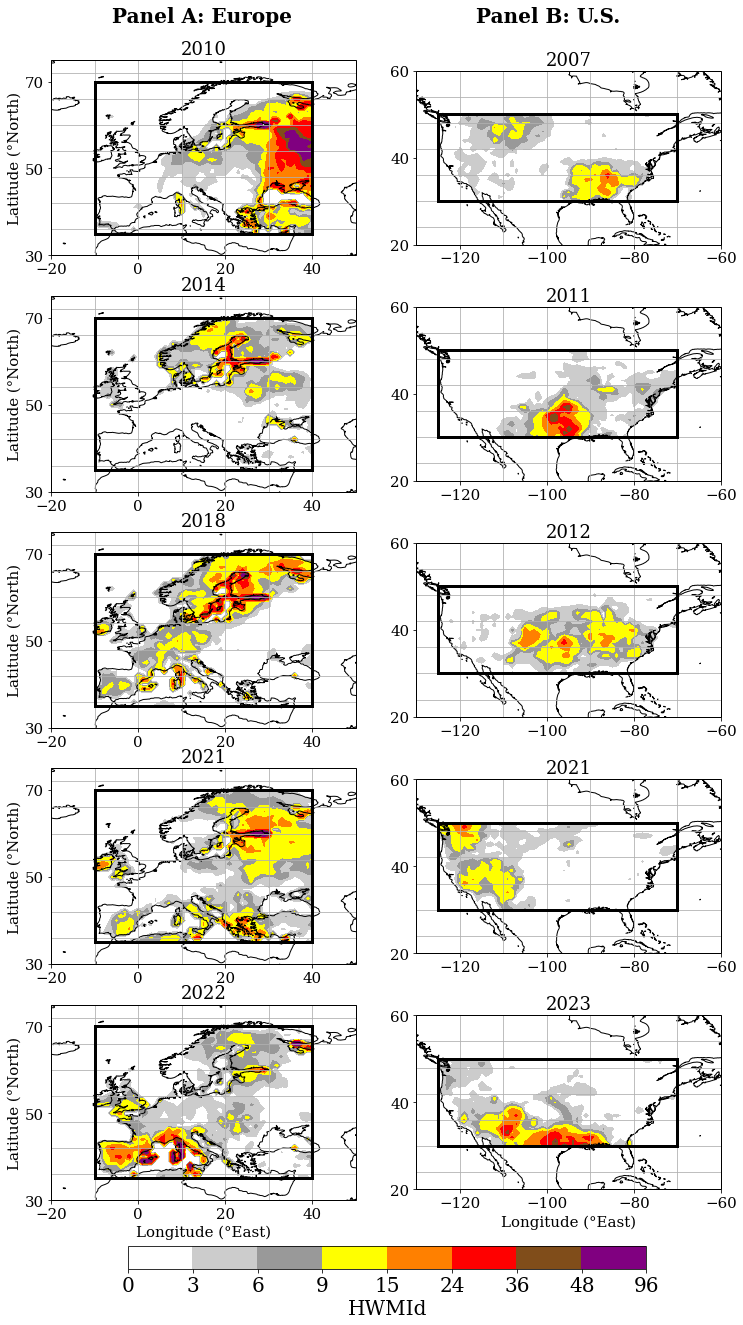

In [76]:
# Set general font size
plt.rcParams['font.size'] = '15'
# Define projection
prj = ccrs.PlateCarree()
levels= np.array([0,3,6,9,15,24,36,48,96])
years_Europe = [year for year in [2010, 2014, 2018, 2021, 2022]]
years_US = [year for year in [2007, 2011, 2012, 2021, 2023]]

# Create non-linear level-spaced colormap, used in Russo et al. 2015
colors = [(1, 1, 1),             # white
          (0.8, 0.8, 0.8),       # light grey
          (0.6, 0.6, 0.6),       # dark grey
          (1, 1, 0),             # yellow
          (1, 0.5, 0),           # light red
          (1, 0, 0),             # red
          (0.5, 0.3, 0.1),       # brown
          (0.5, 0, 0.5)]         # purple

cmap = plt.cm.colors.ListedColormap(colors)
# Create a norm object using BoundaryNorm
norm = plt.cm.colors.BoundaryNorm(levels, cmap.N)
X_Europe, Y_Europe = (HWMID_lat_lon_Europe_xr.lon, HWMID_lat_lon_Europe_xr.lat)
X_USA, Y_USA = (HWMID_lat_lon_USA_xr.lon, HWMID_lat_lon_USA_xr.lat)

X= [X_Europe, X_USA]#, X_Japan]
Y= [Y_Europe, Y_USA]#, Y_Japan]
Z= [HWMID_lat_lon_Europe_xr, HWMID_lat_lon_USA_xr]#, HWMID_lat_lon_Japan_xr]

for r in range(1):
    fig = plt.figure(figsize=(12,21))
    axs=[]
    for i in range(1,11):
            axs.append(fig.add_subplot(5,2,i, projection=prj))
    print()
    E=0
    U=0
    for j in range(0,10):
        if j%2==0:
            contf= axs[j].contourf(X_Europe,Y_Europe, HWMID_lat_lon_Europe_xr.sel(year=years_Europe[E]).squeeze(), cmap=cmap, levels=levels, transform=prj, norm=norm)
            axs[j].set_title(years_Europe[E])            
            axs[j].plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=3)
            axs[j].set_extent([-20, 50, 30, 75], prj)
            axs[j].set_xticks([-20, 0, 20, 40],crs=prj)
            axs[j].set_yticks([30, 50, 70],crs=prj)
            E=E+1
        elif j%2==1:
            contf= axs[j].contourf(X_USA,Y_USA, HWMID_lat_lon_USA_xr.sel(year=years_US[U]).squeeze(), cmap=cmap, levels=levels, transform=prj, norm=norm)
            axs[j].set_title(years_US[U])            
            axs[j].plot(x5, y5, x6, y6,x7,y7,x8,y8, color='black', linestyle='-', linewidth=3)
            axs[j].set_extent([-130, -60, 20, 60], prj)
            axs[j].set_xticks([-120,-100, -80, -60],crs=prj)
            axs[j].set_yticks([20, 40, 60],crs=prj)
            U=U+1

    for ax in axs:
        ax.coastlines('50m')
        ax.gridlines()
    axs[0].set_ylabel('Latitude (°North)')
    axs[2].set_ylabel('Latitude (°North)')
    axs[4].set_ylabel('Latitude (°North)')
    axs[6].set_ylabel('Latitude (°North)')
    axs[8].set_ylabel('Latitude (°North)')
    axs[8].set_xlabel('Longitude (°East)')
    axs[9].set_xlabel('Longitude (°East)')

       # axs[0].text(-0.07, 0.55, 'Latitude', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
       # ax.text(0.5, -0.3, 'Longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)

    cb_ax = fig.add_axes([0.214, 0.08, 0.6, 0.015])
    cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
    cb.ax.tick_params(labelsize=20)
    cb.set_label(label='HWMId', fontsize=20)
    
plt.figtext(0.3,0.915,"Panel A: Europe", ha="center", va="top", fontweight='bold', fontsize=20)
plt.figtext(0.7,0.915,"Panel B: U.S.", ha="center", va="top", fontweight='bold', fontsize=20)

#plt.figtext(0.09,0.74, "c)", ha="center", va="top", fontsize=20)
#plt.figtext(0.51,0.74,"d)", ha="center", va="top", fontsize=20)#

#plt.figtext(0.09,0.5825,"e)", ha="center", va="top", fontsize=20)
#plt.figtext(0.51,0.5825,"f)", ha="center", va="top", fontsize=20)

#plt.figtext(0.09,0.425,"g)", ha="center", va="top", fontsize=20)
#plt.figtext(0.51,0.425,"h)", ha="center", va="top", fontsize=20)

#plt.figtext(0.09,0.27,"i)", ha="center", va="top", fontsize=20)
#plt.figtext(0.51,0.27,"j)", ha="center", va="top", fontsize=20)

#rasterize_list = [axs[s] for s in range(10)]
plt.savefig('HWMId_JK/figs/ERA5_Europe_US_HWMId_top5_incl_2023.pdf', dpi=300)

### Search for gridpoint of maximum HWMId for each year and for Heat wave extent

                 Europe
Year   HWMId-Peak   Lon        Lat     Extent
1979       40       -4.0°E     35.0°N      0%
1980       107       18.0°E     66.0°N      2%
1981       90       38.0°E     56.0°N      0%
1982       141       13.0°E     59.0°N      3%
1983       277       8.0°E     40.0°N      4%
1984       116       -6.0°E     50.0°N      0%
1985       61       36.0°E     37.0°N      0%
1986       69       9.0°E     60.0°N      0%
1987       132       22.0°E     45.0°N      4%
1988       131       24.0°E     66.0°N      5%
1989       126       -8.0°E     53.0°N      1%
1990       117       -8.0°E     43.0°N      1%
1991       108       26.0°E     60.0°N      1%
1992       151       10.0°E     42.0°N      0%
1993       56       40.0°E     39.0°N      0%
1994       202       13.0°E     55.0°N      11%
1995       199       -7.0°E     52.0°N      3%
1996       99       35.0°E     45.0°N      1%
1997       302       13.0°E     55.0°N      3%
1998       215       20.0°E     39.0°N      

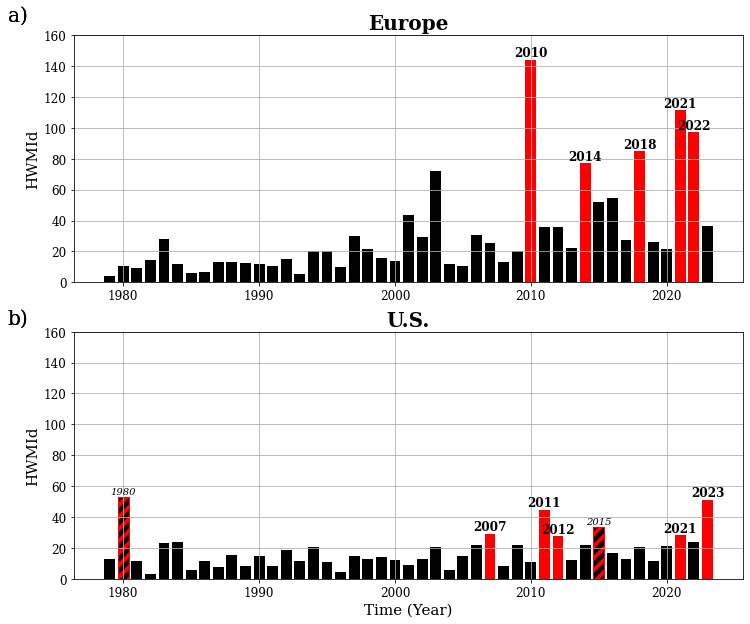

In [19]:
extent_threshold=6
mpl.rcParams['hatch.linewidth'] = 4.0  # previous svg hatch linewidth
HWMId_region = [HWMID_lat_lon_Europe_xr, HWMID_lat_lon_USA_xr]#, HWMID_lat_lon_Japan_xr]
HWMID_max_idx_sorted_region={}
region=['Europe', 'U.S.']#, 'Japan']
years=[str(y) for y in np.arange(1979,2024)]

fig= plt.figure(figsize=[12,10])
axs=[]
for i in range(1,len(region)+1):
    axs.append(fig.add_subplot(len(region),1,i))
    
for r in range(len(region)):
    if r==0:
        print('                 Europe')
    elif r==1:
        print('                 U.S.')
    elif r==2:
        print('                 Japan')
    print('Year', '  HWMId-Peak','  Lon','       Lat','    Extent')
    HWMID_max_idx=[]
    HWMID_extent=[]
    for year in years:
        HWMID_max_idx.append(HWMId_region[r].sel(year=slice(year,year)).where(HWMId_region[r].sel(year=slice(year,year))==HWMId_region[r].sel(year=slice(year,year)).max(), drop=True).squeeze())
        HWMID_extent.append(HWMId_region[r].sel(year=slice(year,year)).where(HWMId_region[r].sel(year=slice(year,year))>=extent_threshold, drop=True).squeeze().count().values/ HWMId_region[r].sel(year=slice(year,year)).count().values)
        print(year, 
              '      '+str(int(HWMID_max_idx[-1].values*10)),
              '      '+str(HWMID_max_idx[-1].lon.values)+'°E', 
              '    '+str(HWMID_max_idx[-1].lat.values)+'°N',
              '     '+str(int(HWMID_extent[-1]*100))+'%')

    HWMID_max_idx_concat = xr.concat(HWMID_max_idx, dim='year')
    HWMID_max_idx_sorted = HWMID_max_idx_concat.sortby(HWMID_max_idx_concat, ascending=False)
    HWMID_max_idx_sorted_region[region[r]]= HWMID_max_idx_sorted

#    HWMID_extent_concat = xr.concat(HWMID_extent, dim='year')
#    HWMID_extent_sorted = HWMID_extent_concat.sortby(HWMID_extent_concat, ascending=False)
#    HWMID_extent_sorted_region[region[r]]= HWMID_extent_sorted
    
    print(HWMID_max_idx_sorted_region[region[r]].year.values[:10])
#    print(HWMID_extent_sorted_region[region[r]].year.values[:10])

    print(HWMID_max_idx_sorted_region[region[r]].values[:10])
    axs[r].bar(HWMID_max_idx_concat.year, HWMID_max_idx_concat, color='black')
    axs[1].set_xlabel('Time (Year)', fontsize=15)
    axs[r].set_ylabel('HWMId', fontsize=15)
    axs[r].set_ylim([0,160])
    axs[r].grid()
    if r==0 or r==2:
        #axs[r].bar(HWMID_max_idx_sorted.year[:6], HWMID_max_idx_sorted[:6], color='red')
        #axs[r].bar(HWMID_max_idx_sorted.year[7], HWMID_max_idx_sorted[7], color='red')
        for h in [0,1,2,3,4]:
            axs[r].bar(HWMID_max_idx_sorted.year[h], HWMID_max_idx_sorted[h], color='red')
            axs[r].text(HWMID_max_idx_sorted.year[h], HWMID_max_idx_sorted[h],str(HWMID_max_idx_sorted.year.values[h]), fontsize='medium', horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    elif r==1:
        for h in [1,2,4,5,6]:
            axs[r].bar(HWMID_max_idx_sorted.year[h], HWMID_max_idx_sorted[h], color='red')
            axs[r].text(HWMID_max_idx_sorted.year[h], HWMID_max_idx_sorted[h],str(HWMID_max_idx_sorted.year.values[h]), fontsize='medium', horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
        for h in [0,3]:
            axs[r].bar(HWMID_max_idx_sorted.year[h], HWMID_max_idx_sorted[h], color='black', hatch='//', edgecolor='red')
            axs[r].text(HWMID_max_idx_sorted.year[h], HWMID_max_idx_sorted[h],str(HWMID_max_idx_sorted.year.values[h]), fontsize='small', horizontalalignment='center', verticalalignment='bottom', style='italic')
    
    plt.figtext(0.06,0.92,"a)", ha="center", va="top", fontsize=20)
    plt.figtext(0.06,0.5,"b)", ha="center", va="top", fontsize=20)
    axs[r].set_title(region[r], fontweight='bold', fontsize=20)
    rasterize_list = [axs[s] for s in range(1)]
    plt.savefig('HWMId_JK/figs/Fig.1.4.png')
#HWMID_extent_concat= xr.DataArray(HWMID_extent,name='extent', dims=['year'], coords=dict(year=HWMID_lat_lon_xr.year))

### Look for heat wave start date and duration in daily heat wave magnitudes

 The 2010 heat wave in Europe started on ['05/07/2010'] and ended on ['18/08/2010'] with a length in days of [45]
 The 2021 heat wave in Europe started on ['18/06/2021'] and ended on ['19/07/2021'] with a length in days of [32]
 The 2022 heat wave in Europe started on ['03/07/2022'] and ended on ['17/09/2022'] with a length in days of [77]
 The 2018 heat wave in Europe started on ['12/07/2018'] and ended on ['11/08/2018'] with a length in days of [31]
 The 2014 heat wave in Europe started on ['18/07/2014'] and ended on ['14/08/2014'] with a length in days of [28]
 The 2023 heat wave in U.S. started on ['26/07/2023'] and ended on ['28/08/2023'] with a length in days of [34]
 The 2011 heat wave in U.S. started on ['16/07/2011'] and ended on ['08/08/2011'] with a length in days of [24]
 The 2007 heat wave in U.S. started on ['04/08/2007'] and ended on ['28/08/2007'] with a length in days of [25]
 The 2021 heat wave in U.S. started on ['26/06/2021'] and ended on ['04/07/2021'] with a lengt

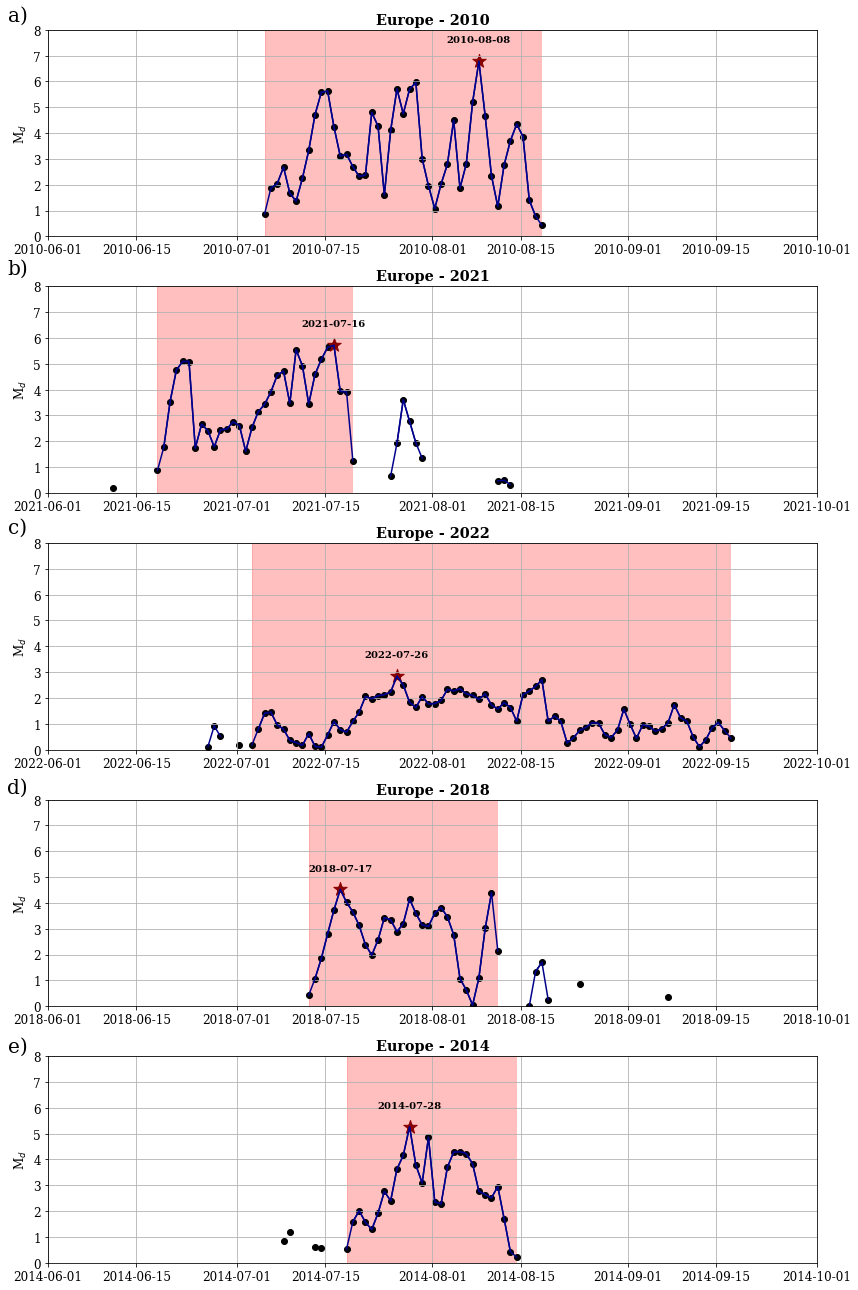

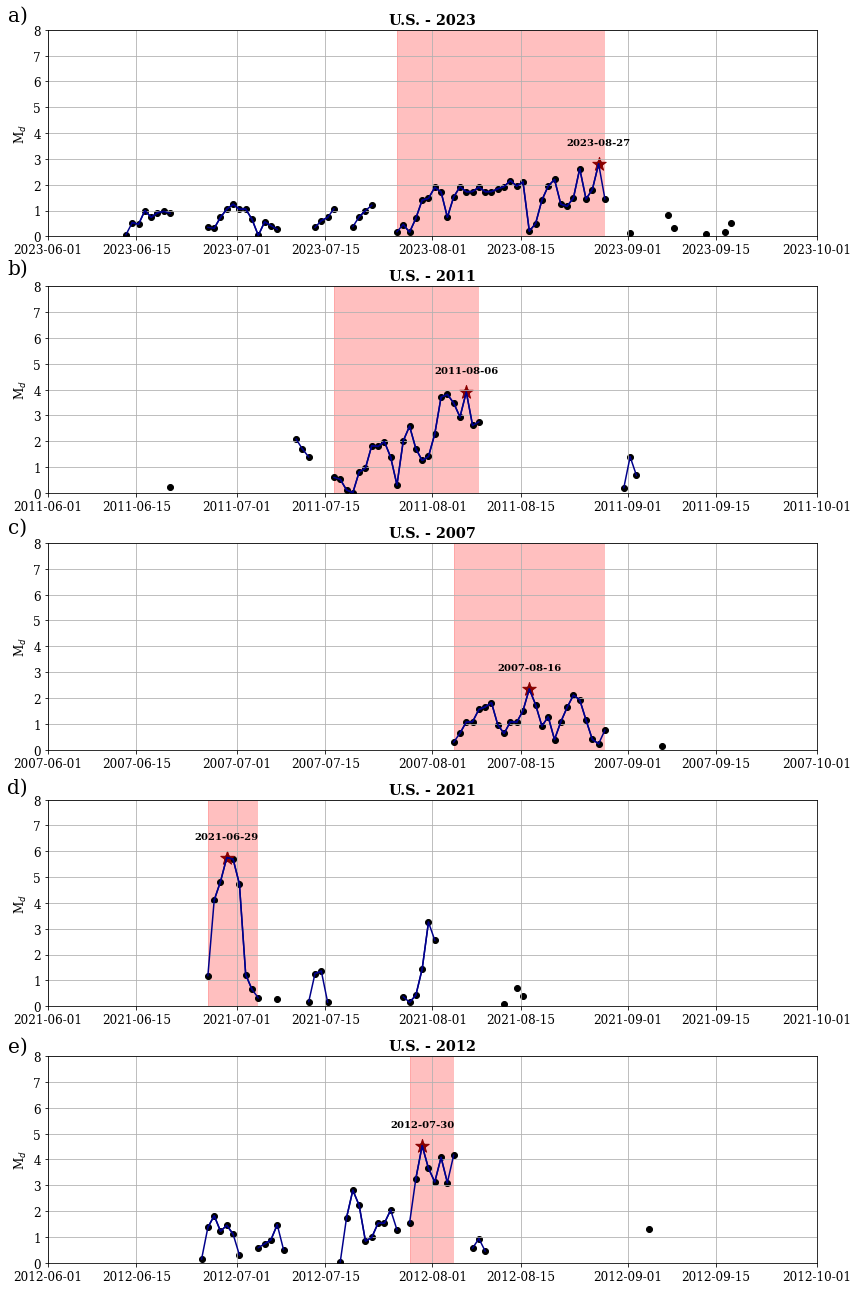

In [70]:
# Set general font size
plt.rcParams['font.size'] = '12'
Md_lat_lon_region = [Md_lat_lon_Europe_xr, Md_lat_lon_USA_xr]#, Md_lat_lon_Japan_xr]
USA_hw_idx= [1,2,4,5,6] # Selected USA heat waves available for the stock market analysis and with sufficient spatial extent
start_date=[]
end_date=[]
reg =['Europe','USA']
hw_Md={}
k=0
for r in range(len(region)):
    fig= plt.figure(figsize=[12,18])
    axs=[]
    for i in range(1,6):
            axs.append(fig.add_subplot(5,1,i))
    for i in range(5):
        hw_top_year=HWMID_max_idx_sorted_region[region[r]].year[i].values
        if r==1:
                hw_top_year=HWMID_max_idx_sorted_region[region[r]].year[USA_hw_idx[i]].values

        test = Md_lat_lon_region[r].sel(lon=HWMID_max_idx_sorted_region[region[r]].sel(year=hw_top_year).lon.values, lat= HWMID_max_idx_sorted_region[region[r]].sel(year=hw_top_year).lat.values, time=str(hw_top_year)).squeeze()
        #### Find heat wave start, end time and duration
        test_max = test.where(test==test.max(), drop=True)
        start_val=[]
        for d in range(len(test)):
            start_val.append(test.where(test.time==((test_max.time - pd.Timedelta(str(d)+" days")).assign_coords(time=test_max.time - pd.Timedelta(str(d)+" days")))))
            if start_val[d].isnull():
                start_date.append(start_val[-2])
                break
          
        end_val=[]
        for d in range(len(test)):
            end_val.append(test.where(test.time==((test_max.time + pd.Timedelta(str(d)+" days")).assign_coords(time=test_max.time + pd.Timedelta(str(d)+" days")))))
            if end_val[d].isnull():
                end_date.append(end_val[-2])
                break
        print(" The "+str(hw_top_year)+ " heat wave in "+region[r]+" started on "+ str(start_date[-1].time.dt.strftime("%d/%m/%Y").values)+" and ended on "+ str(end_date[-1].time.dt.strftime("%d/%m/%Y").values)+" with a length in days of "+str((end_date[-1].time.values - start_date[-1].time.values)/86400000000000+1))
        
        #### SAVE DAILY MAGNITUDES IN DICT
        hw_ls = [  '_2010',
                   '_2021',
                   '_2022',
                   '_2018',
                   '_2014',
                   '_2023',   
                   '_2011',
                   '_2007',
                   '_2021',
                   '_2012']

        hw_Md [reg[r]+hw_ls[k]] = test.where(test.time.values >= start_date[-1].time.values).where(test.time.values <= end_date[-1].time.values).dropna('time')
        k=k+1
        ####
        axs[i].fill_between(test.time.where(test.time>=start_date[-1].time.values),0,8, color='red', alpha=0.25)
        axs[i].fill_between(test.time.where(test.time>=end_date[-1].time.values),0,8, color='white', alpha=1)
        axs[i].text(test_max.time, test_max+1,str(test_max.time.dt.strftime("%Y-%m-%d").values)[2:-2], fontsize='small', horizontalalignment='center', verticalalignment='top', fontweight='bold')
        axs[i].scatter(test.time, test, color='black')
        axs[i].scatter(test.where(test==test.max()).time, test.where(test==test.max()), color='darkred', marker='*', s=200)
        axs[i].plot(test.time , test.where(test.shift(time=-1).notnull()), lw=1.5, color='darkblue')
        axs[i].plot(test.time , test.where(test.shift(time=+1).notnull()), lw=1.5, color='darkblue')
        axs[i].set_title(region[r]+' - '+ str(hw_top_year), fontweight='bold')
        axs[i].set_xlim(datetime(hw_top_year, 6, 1), datetime(hw_top_year, 10, 1))
        axs[i].set_ylim([0,8])
        axs[i].set_ylabel('M$_d$', fontsize=12)
        axs[i].grid()
    plt.tight_layout()
    plt.figtext(0.02,0.995,"a)", ha="center", va="top", fontsize=20)
    plt.figtext(0.02,0.8,"b)", ha="center", va="top", fontsize=20)
    plt.figtext(0.02,0.6,"c)", ha="center", va="top", fontsize=20)
    plt.figtext(0.02,0.4,"d)", ha="center", va="top", fontsize=20)
    plt.figtext(0.02,0.2,"e)", ha="center", va="top", fontsize=20)
    
    rasterize_list = [axs[s] for s in range(5)]
#    raste(r.rasterize_and_save('HWMId_JK/figs/ERA5_'+region[r]+'_HWMId_daily_mag_top5_incl_2023.pdf', rasterize_list, dpi=300)

    


In [71]:
%store hw_Md

Stored 'hw_Md' (dict)
